## Template detection in image with cv2.matchTemplate

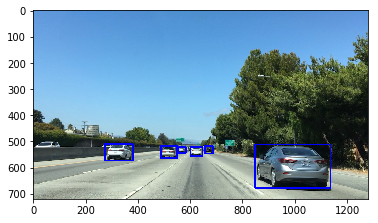

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

image = mpimg.imread('/home/markus/udacity/Projekte/CarNDVehicleDetectionP1/test_images/template_matching/bbox-example-image.jpg')
templist = glob.glob('/home/markus/udacity/Projekte/CarNDVehicleDetectionP1/test_images/template_matching/cutout*.jpg')
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
    
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    for temp in templist:
        img_tmp = mpimg.imread(temp)
        match = cv2.matchTemplate(img,img_tmp,method=0)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(match)
        bbox_list.append((minLoc,(minLoc[0]+img_tmp.shape[1],minLoc[1]+img_tmp.shape[0])))
    return bbox_list

bboxes = find_matches(image,templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

# Build and Train a Classifier for Car Detection in Images

In this section the classifier is designed that will later be used to detect cars in a video stream. In the next section the training of the classifier is addressed.

In [2]:
# import packages that are required for computations in this notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

For the training of the classifier, the vehicle and non-vehicle images of the git repository training_datasets will be used. The file paths to the images are first loaded with glob and stored in the lists cars[] and nocars[] respectively.

In [3]:
cars = glob.glob('./training_datasets/vehicles/*/*.jpeg', recursive=True)
nocars = glob.glob('./training_datasets/non-vehicles/*/*.jpeg', recursive=True)

In the following the 'RGB' representation of a randomly selected car image will be transformed into different color spaces and the pixel values of the test image will be shown in 3d plots for each colorspace.

In [4]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(imglist, colors_rgb,
        csplist, axis_limits=[(0, 255), (0, 255), (0, 255)]):

    # Create figure and 3D axes
    fig = plt.figure(figsize=(15, 10))
    for i in range(len(imglist)):
        pixels = imglist[i]
        axis_labels = list(csplist[i])
        
        ax = fig.add_subplot(2,3,i+1,projection='3d')

        # Set axis limits
        ax.set_xlim(*axis_limits[0])
        ax.set_ylim(*axis_limits[1])
        ax.set_zlim(*axis_limits[2])

        # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=8, pad=8)
        ax.set_xlabel(axis_labels[0], fontsize=8, labelpad=8)
        ax.set_ylabel(axis_labels[1], fontsize=8, labelpad=8)
        ax.set_zlabel(axis_labels[2], fontsize=8, labelpad=8)

        # Plot pixel values with colors given in colors_rgb
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    plt.show()

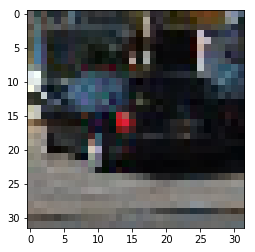

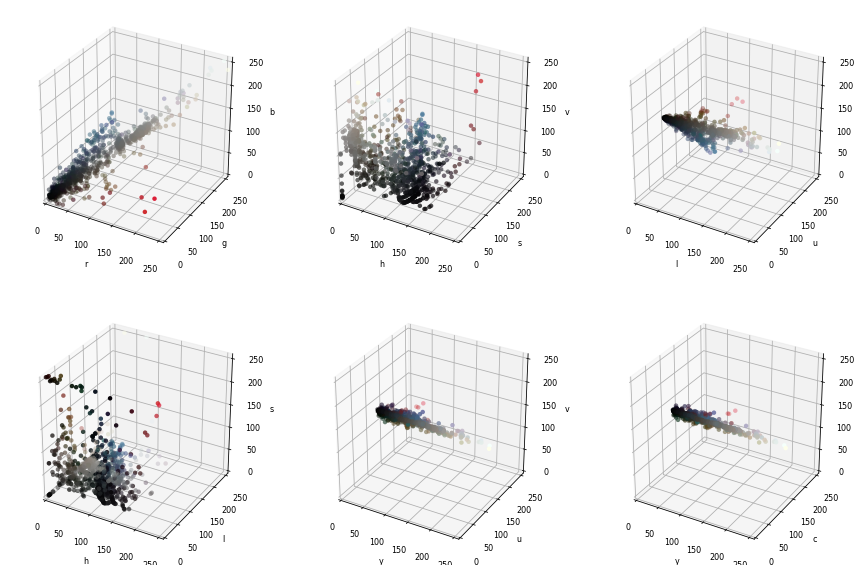

In [13]:
sel = np.random.randint(0,len(cars))
img = mpimg.imread(cars[sel])
img = cv2.resize(img, dsize=(32,32), interpolation=cv2.INTER_NEAREST)
plt.imshow(img)
img_rgb = np.copy(img)
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
img_rgbc = img_rgb / 255.

img_list = [img_rgb,img_hsv,img_luv,img_hls,img_yuv,img_ycrcb]
csp_list = ['rgb','hsv','luv','hls','yuv','ycrcb']

plot3d(img_list,img_rgbc,csp_list)

=> Especially the 'HLS' and 'HSV' colorspaces show a nice separation of car pixels and background so that a transformation into these colorspaces might be able to help the classification.

In the following section the functions for feature extraction from a test image are defined. These are:

* color histograms
* spatial color binning
* and hog features

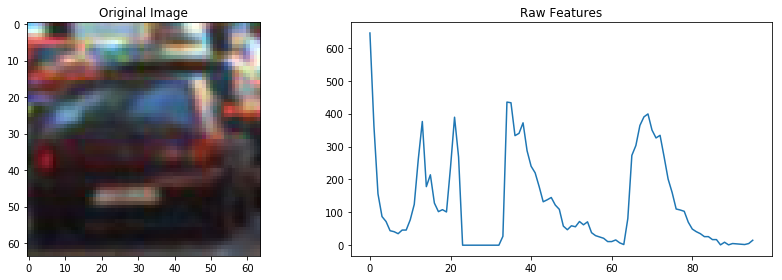

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# print (HLS) color histogram for test image
sel = np.random.randint(0,len(cars))
img = mpimg.imread(cars[sel])
f_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.plot(color_hist(f_img))
plt.title('Raw Features')
fig.tight_layout()

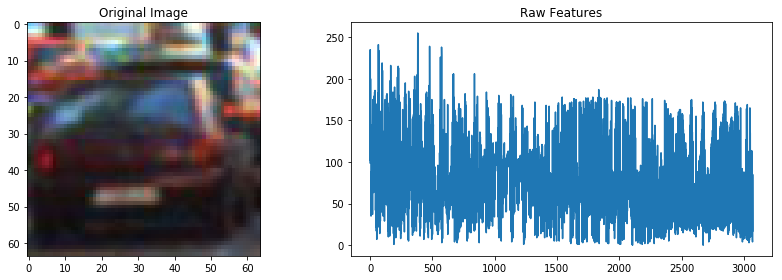

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# print (HLS) spatial binning for same test image as above
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.plot(bin_spatial(f_img))
plt.title('Raw Features')
fig.tight_layout()

/home/markus/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


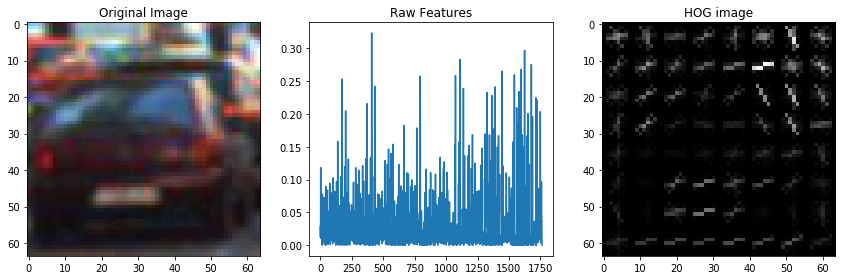

In [8]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# print hog features for grayscale version of same test image as above
f_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features,hog_image = get_hog_features(f_img,vis=True)
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(132)
plt.plot(hog_features)
plt.title('Raw Features')
plt.subplot(133)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG image')
fig.tight_layout()

In [9]:
def extract_features(imgstrs, cspace='RGB', hist_bins=32, hist_range=(0, 256),
                                            spatial_size=(32, 32),
                                            orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    features = []
    for imgstr in imgstrs:
        img = mpimg.imread(imgstr)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
        features_colhist = color_hist(feature_image,nbins=hist_bins,bins_range=hist_range)
        features_spatial = bin_spatial(feature_image,size=spatial_size)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(np.concatenate((features_spatial,features_colhist,hog_features)))
    return features

In [10]:
from sklearn.preprocessing import StandardScaler

# extract features from images:
car_features = extract_features(cars, cspace='HLS')
nocar_features = extract_features(nocars, cspace='HLS')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, nocar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
else:
     print('function only returns empty feature vectors...')
        
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))

/home/markus/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [11]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time

#parameters = {'C':[1, 10]}
clf = SVC(kernel='linear')
#clf = GridSearchCV(svr, parameters) 
#print(clf.best_params_)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 0.  1.  1.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  0.  1.  0.  0.  1.]
0.0329 Seconds to predict 10 labels with SVC


# Detect cars in images by sliding window search